# Pest risk prediction and decision model

This notebook is meant as supplementary data to the paper **"Combining spatio-temporal pest risk prediction and decision theory to improve pest management in smallholder agriculture** by Johannes Kopton et al.

For more information on the conceptual framework etc. please refer to the paper.

In this notebook:

* the pest risk model is trained and
* evaluated using cross-validation
* pest risk is predicted over a grid
* the value of monitoring (EVPI) is calculated
* decision recommendations are computed

To run this on your own data you need:

* observation data with the following columns
    * latitude
    * longitude
    * timestamp
    * presence/absence
    * your covatiates (e.g. weather timeseries)
* inference data on a grid
    * geodata for your grid cells
    * covariate data for each grid cell

This notebook was tested on [Google Colab](https://colab.research.google.com/). If possible it is recommended to use a GPU VM (e.g. Nvidia T4 GPU), because training will run much faster.

## Synthetic data
The data was kindly provided by the Plantix team, who develop a mobile application for smallholder farmers. To protect the privacy of the Plantix users, the data used in this example does not contain the exact locations of the observations. This, the results are slightly different than the ones presented in the paper. To generate the data for this paper, locations were randomly samples within each 11x11km grid cell.

## Installation and imports

Install GPyTorch (Gaussian Process library using PyTorch as backend)

In [ ]:
!pip install gpytorch

Install Latex for using proper math in figures

In [ ]:
!sudo apt update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Imports

In [ ]:
!git clone https://github.com/johanneskopton/pest-risk-decision.git

In [166]:
import os
import copy
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import gpytorch
import sklearn.model_selection

from tqdm import tqdm

import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
matplotlib.warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "rmfamily"
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

import sys
from pathlib import Path

sys.path.append(str(Path("pest-risk-decision")))

from gp_model import GPClassificationModel
from utils import DataPreprocessor, \
    destandardize_date, \
    plot_cross_validation_roc, \
    beauty_print_date

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data preparation

Reference for normalization:

The `date` column in the dataset is the number of days since the reference day.

`location_min` is the minimum (latitude, longitude) for normalization. For coherent predictions, these fixed values are used (instead of calculating it every time from the datasets).

In [7]:
reference_day = pd.Timestamp("2018-01-01")

location_min = np.array([12.587, 76.770])

Load data

In [8]:
df = pd.read_feather('pest-risk-decision/data/combined_synthetic1.feather')
df.tail()

,date,cell_id,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,surface_pressure,solar_radiation,temperature,total_evaporation_sum,precipitation,wind_speed,...,wind_speed_l23,wind_speed_l24,wind_speed_l25,wind_speed_l26,wind_speed_l27,wind_speed_l28,wind_speed_l29,longitude,latitude,presence
51266,2200,"779,156",0.000000,1.052856,97607.117188,14457044.0,297.781616,-0.000450,0.000107,2.338717,...,2.636389,2.396101,1.851577,1.888492,2.227981,2.230396,2.036004,77.970111,15.603431,0
10867,2200,"782,138",2.473882,1.069814,95068.820312,16391444.0,295.399628,-0.002085,0.000020,2.329225,...,3.003732,2.741731,2.520000,2.234132,2.239941,2.021110,1.647149,78.257444,13.873215,1
45988,2200,"783,158",0.774048,0.847010,97921.117188,15063304.0,297.996796,-0.000774,0.000014,1.993090,...,2.280198,2.204298,1.786362,1.865160,2.089570,2.110225,1.862011,78.380267,15.826743,0
60365,2200,"798,164",2.422618,1.575623,100097.945312,17080932.0,298.277893,-0.001716,0.000002,1.538398,...,1.375999,1.709825,1.043014,1.507334,1.349146,0.932436,0.430954,79.852395,16.410576,0
67947,2200,"825,178",2.329763,1.900945,92963.945312,16640100.0,293.696259,-0.002532,0.000002,0.349289,...,0.526726,0.576462,0.226500,0.729335,0.864196,0.605803,0.181677,82.509489,17.885369,0


Prepare covariate variables

Preprocess data (normalization etc.), see. `utils.py` for more details

In [9]:
variables = [
    "temperature",
    "relative_humidity",
    "solar_radiation",
    "total_evaporation_sum",
    "wind_speed",
    "surface_pressure",
    "precipitation",
    "leaf_area_index_high_vegetation",
    "leaf_area_index_low_vegetation",
]

suffixes = [""]

for lag_i in range(1, 30):
    suffixes.append(f"_l{lag_i}")

vars = []
for var in variables:
    for suffix in suffixes:
        vars.append(var+suffix)

In [12]:
data_preprocessor = DataPreprocessor(
    df,
    vars,
    "presence",
    location_min,
)
XY = data_preprocessor.get_XY(df)

Store the preprocessed dataset in pytorch tensors (predictor matrix `X` and predictand vector `y`) and move it onto the GPU for accelerated training and inference.

Then split the data at the end of 2021 to create a training and a testing dataset for validation. In addition to that, create a `TimeSeriesSplit` for cross-validation.

In [28]:
N_CV_SPLITS = 2

X = torch.from_numpy(data_preprocessor.get_X_numpy(df)).float().contiguous().to(device)
y = torch.from_numpy(data_preprocessor.get_Y_numpy(df)).int().contiguous().to(device)
cv = sklearn.model_selection.TimeSeriesSplit(n_splits=N_CV_SPLITS)

print(destandardize_date(1460, reference_day).strftime("%Y-%m-%d"))
print(destandardize_date(1825, reference_day).strftime("%Y-%m-%d"))

train_idxs = X[:, 2] <= 1460/365
test_idxs = (X[:, 2] > 1460/365) & (X[:, 2] <= 1825/365)

train_X = X[train_idxs, :]
test_X = X[test_idxs, :]
train_y = y[train_idxs]
test_y = y[test_idxs]

2021-12-31
2022-12-31


## Data visualization

Plot spatial distribution of samples

<Axes: xlabel='t_lon', ylabel='t_lat'>

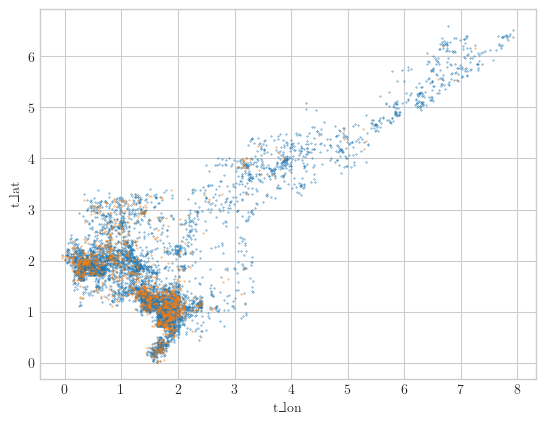

In [54]:
fig, ax = plt.subplots(1)
XY[(y==0).cpu().numpy()].plot.scatter("t_lon", "t_lat", c="C0", s=0.1, ax=ax)
XY[(y==1).cpu().numpy()].plot.scatter("t_lon", "t_lat", c="C1", s=0.1, ax=ax)

Plot presence/absence over pairwise covariates

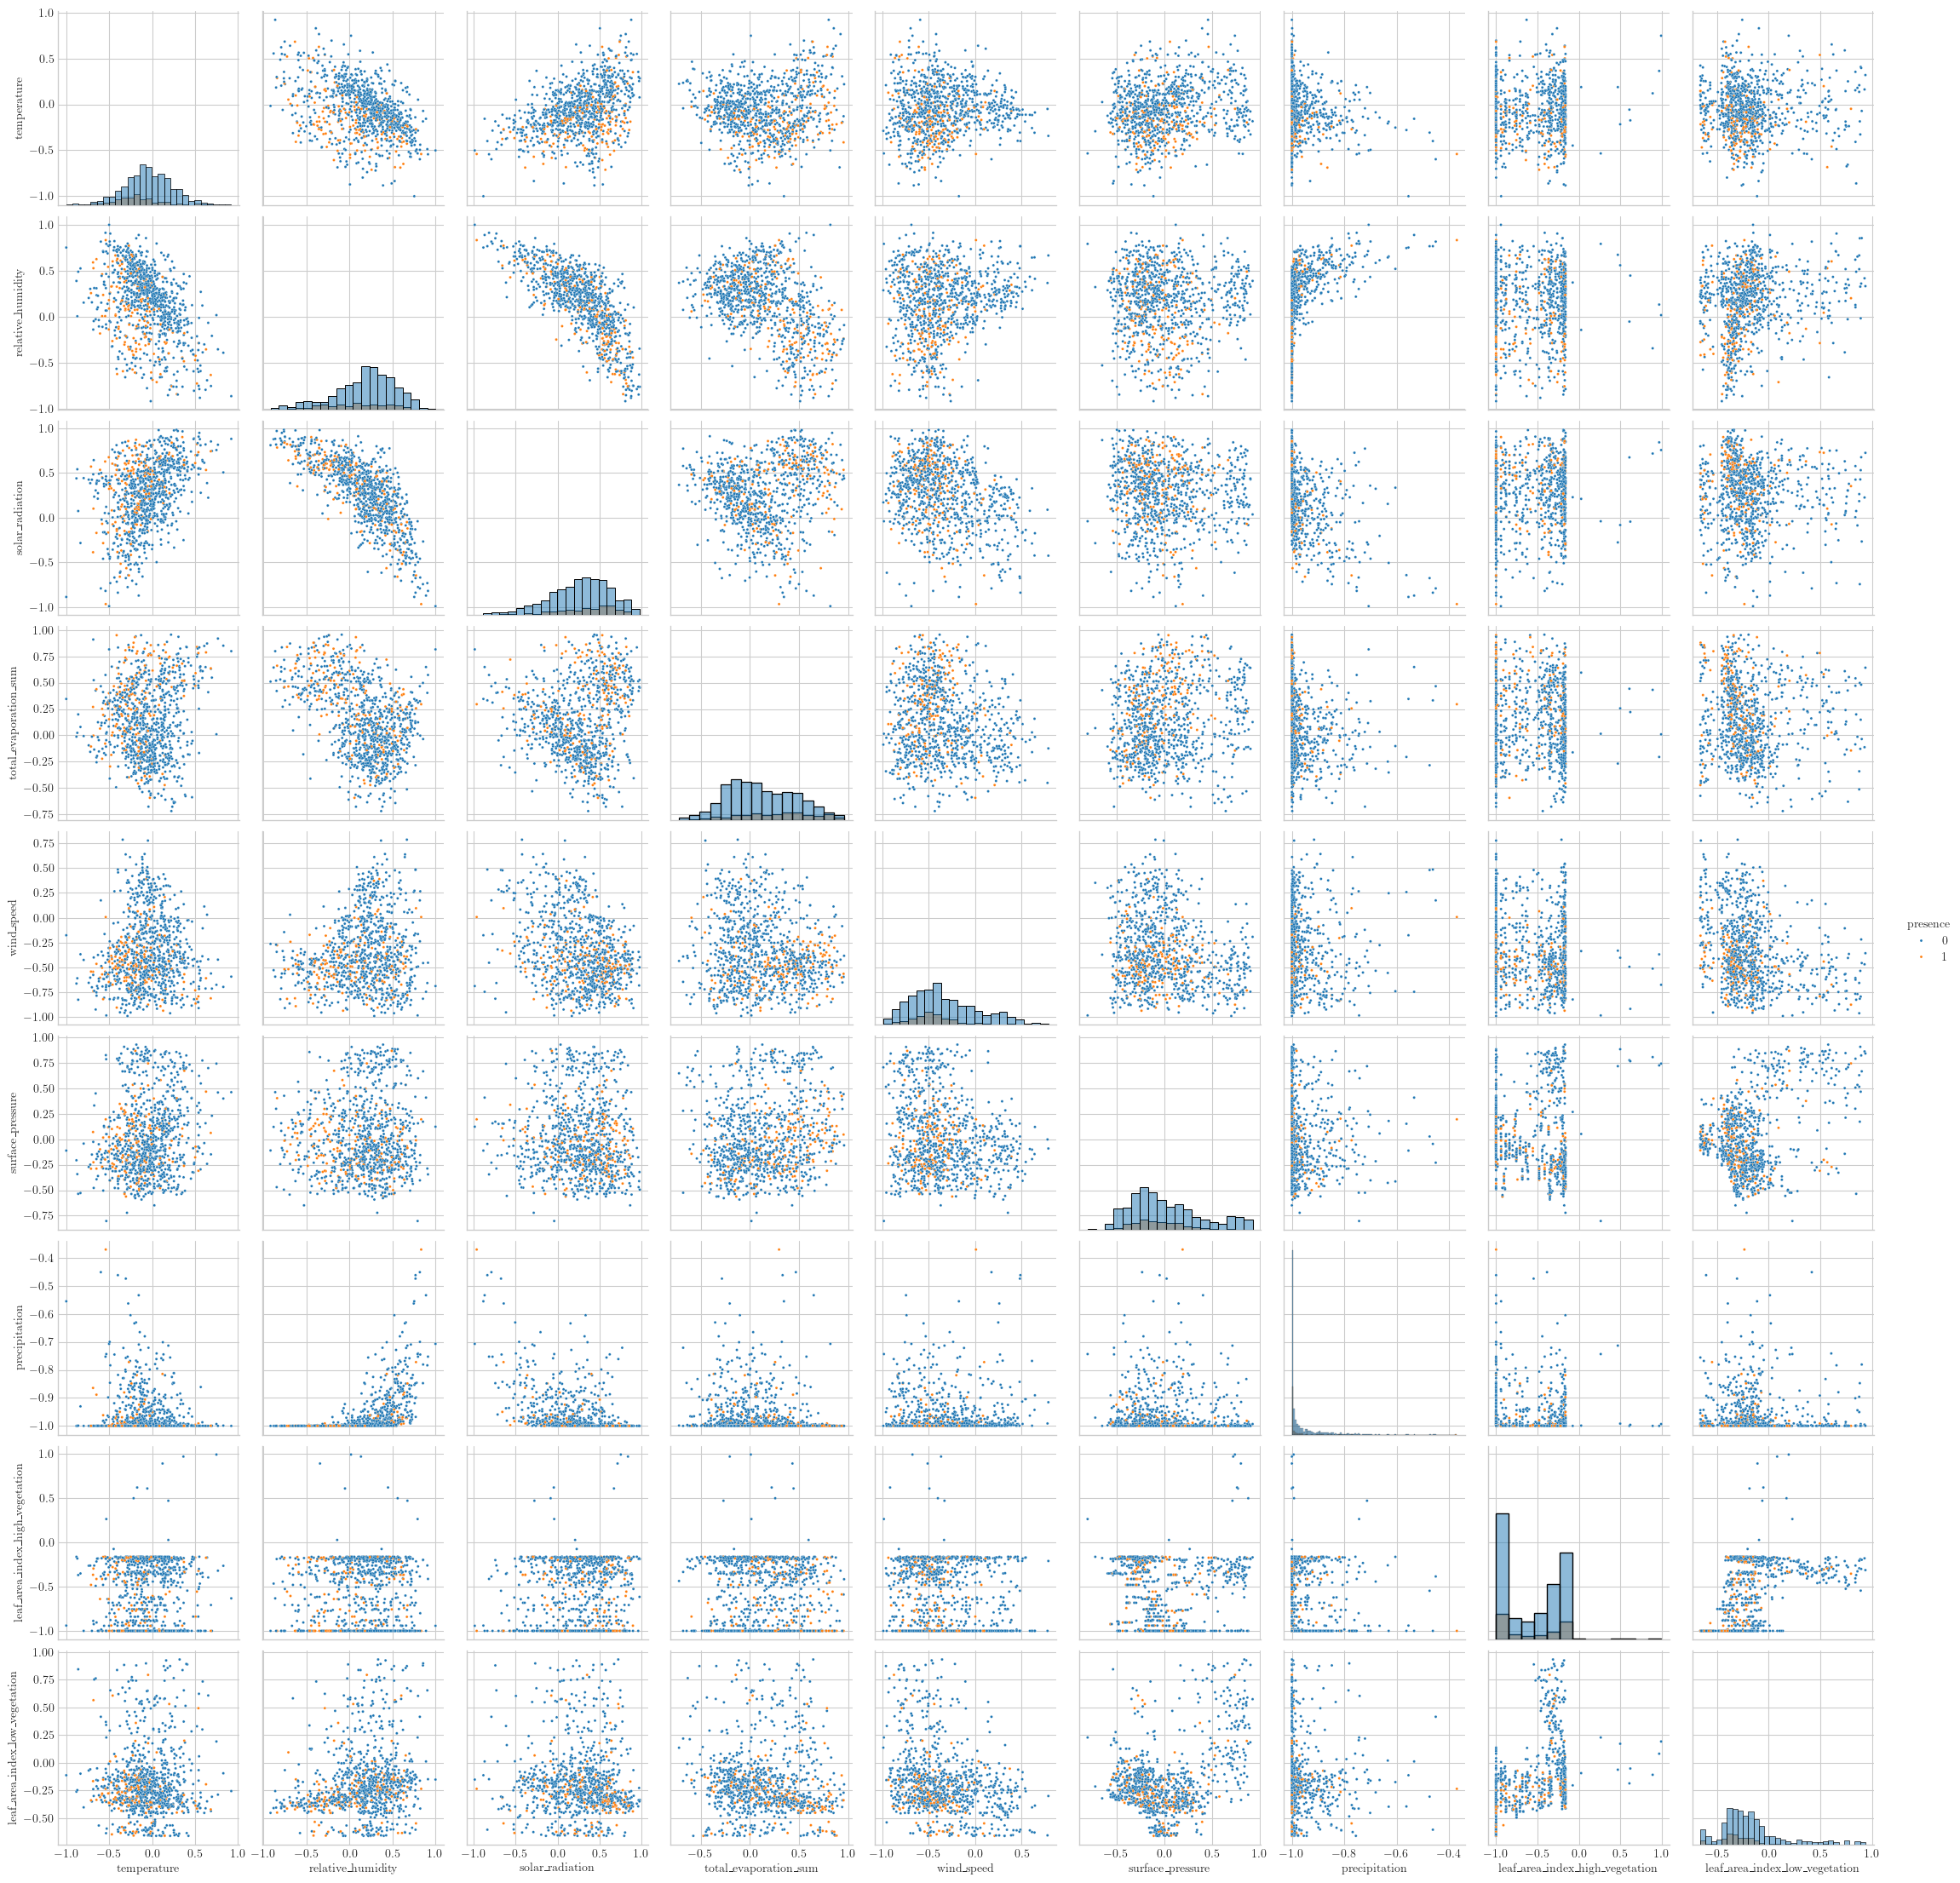

In [53]:
sns.pairplot(XY[variables+["presence"]].sample(1000), hue="presence", diag_kind="hist", plot_kws={"s": 5})

## Training

Set some hyperparameters

In [72]:
N_INDUCING_POINTS = 24              # for the sparse Gaussian process
N_TRAINING_ITERATIONS_HYPER = 512   # number of iterations to train the kernel (hyper-)params
N_TRAINING_ITERATIONS_VI = 50       # number of iterations for the variation inference

N_INFERENCE_SAMPLES = 10000         # how many sample to include in inference (=all)
TEST_DAYS_BATCH_SIZE = 1            # test each day individually for most accurate (but slower) cross-validation

LR_VARIATIONAL = 0.1                # learning rate for variation inference
LR_NEURAL_NET = 0.001               # learning rate for the neural network layers
LR_HYPERPARAMS = 0.02               # learning rate for the kernel params

DO_CV = True                        # do cross validation

The model training function

In [73]:
def train_model(X, y, pretrained_model=None, pretrained_likelihood=None, used_variational_optimizer=None, silent=False):
    n_covars = X.shape[1]-3

    # Initialize model and likelihood
    inducing_indices = torch.randperm(X.size(0))[:N_INDUCING_POINTS]
    inducing_points = X[inducing_indices, :]

    # The same function is used for training the hyperparams and for just fitting the
    # variational inference distribution. In the latter case use the pretrained model
    if pretrained_model:
        model = pretrained_model
        model.variational_strategy.inducing_points = torch.nn.Parameter(inducing_points)
    else:
        model = GPClassificationModel(inducing_points=inducing_points, n_covars=n_covars).to(device)

    # The same goes for the likelihood
    if pretrained_likelihood:
        likelihood = pretrained_likelihood
    else:
        likelihood = gpytorch.likelihoods.BernoulliLikelihood().to(device)


    model.train()
    likelihood.train()

    if pretrained_model:
        # base on an already used variational optimizer or not
        if used_variational_optimizer:
            variational_ngd_optimizer = used_variational_optimizer
        else:
            variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=LR_VARIATIONAL)

        # use Adam for only the mean (do not fit the actually relevant covariance)
        hyperparameter_optimizer = torch.optim.Adam([
            {'params': model.mean_module.parameters()},
        ], lr=LR_HYPERPARAMS)
    else:
        # use natural gradient descent for variational inference
        variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=LR_VARIATIONAL)

        # use Adam for the neural net (feature extractor), covariance module (actual GP), mean and likelihood
        hyperparameter_optimizer = torch.optim.Adam([
            {'params': model.feature_extractor.parameters(), 'lr': LR_NEURAL_NET},
            {'params': model.covar_module.parameters()},
            {'params': model.mean_module.parameters()},
            {'params': likelihood.parameters()},
        ], lr=LR_HYPERPARAMS)

    # use variational ELBO as loss function for SVI
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, y.numel())

    if pretrained_model:
        n_training_iterations = N_TRAINING_ITERATIONS_VI
    else:
        n_training_iterations = N_TRAINING_ITERATIONS_HYPER

    for i in range(n_training_iterations):
        # zero backpropped gradients from previous iteration
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()

        # get predictive output
        output = model(X)

        # calc loss and backprop gradients
        loss = -mll(output, y)
        loss.backward()
        if ((i%10 == 9) or (i == n_training_iterations-1)) and not silent:
            print('{}Iter {:2d}/{:3d} - Loss: {:3.3}'.format("\t" if pretrained_model else "", i + 1, n_training_iterations, loss.item()))
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

    return model, likelihood, variational_ngd_optimizer


## Cross validation

Train the model `CV_SPLITS` times and perform cross validation (may take a while)

In [77]:
# CV results on test data using all data up to 1 day before for SVI (realistic scenario)
pred_y_test_list = []
obs_y_test_list = []

# CV results on test data using only training data for SVI (for comparison)
pred_y_test2_list = []
obs_y_test2_list = []

# CV results on training data
pred_y_train_list = []
obs_y_train_list = []

# do cross validation
for fold, (train, test) in enumerate(cv.split(X, y)):
    print(f"Fold {fold}")

    train_X = X[train, :]
    train_y = y[train]

    test_X = X[test, :]
    test_y = y[test]

    model, likelihood, optimizer = train_model(train_X, train_y)

    with torch.no_grad():
        pred_y_test2 = likelihood(model(test_X))
        pred_y_train = likelihood(model(train_X))

    if DO_CV:
        predictions = np.empty(0, dtype=float)
        observations = np.empty(0, dtype=float)

        first_test_day = test_X[0, 2].cpu().item()
        last_test_day = test_X[-1, 2].cpu().item()

        possible_test_days = np.arange(first_test_day, last_test_day, 1/365)
        test_days = possible_test_days

        print(f"Testing {len(test_days)} days:")

        for i, test_day in enumerate(test_days):
            obs_mask = test_X[:, 2] < test_day
            test_mask = (test_X[:, 2] >= test_day) & (test_X[:, 2] < test_day + TEST_DAYS_BATCH_SIZE/365)

            if test_mask.sum().cpu() == 0:
                continue

            if i % 20 == 0:
                print("\tTest day {} - {:4d} test samples, {:4d} additional observations".format(
                        i,
                        test_mask.sum().cpu(),
                        obs_mask.sum().cpu(),
                    )
                )
                silent = False
            else:
                silent = True

            obs_X = torch.vstack((train_X, test_X[obs_mask, :]))[-N_INFERENCE_SAMPLES:, :]
            obs_y = torch.cat((train_y, test_y[obs_mask]))[-N_INFERENCE_SAMPLES:]

            inference_model, inference_likelihood, _ = train_model(obs_X, obs_y, model, likelihood, optimizer, silent)

            inference_model.eval()
            inference_likelihood.eval()

            with torch.no_grad():
                pred = inference_likelihood(inference_model(torch.atleast_2d(test_X[test_mask, :])))
                predictions = np.concatenate((predictions, pred.mean.cpu().numpy().flatten()))
                observations = np.concatenate((observations, test_y[test_mask].cpu().numpy().flatten()))

        pred_y_test_list.append(predictions)
        obs_y_test_list.append(observations)


    pred_y_test2_list.append(pred_y_test2.mean.cpu().numpy())
    obs_y_test2_list.append(test_y.cpu().numpy())

    pred_y_train_list.append(pred_y_train.mean.cpu().numpy())
    obs_y_train_list.append(train_y.cpu().numpy())


Fold 0
Iter 10/512 - Loss: 0.721
Iter 20/512 - Loss: 0.636
Iter 30/512 - Loss: 0.578
Iter 40/512 - Loss: 0.535
Iter 50/512 - Loss: 0.501
Iter 60/512 - Loss: 0.473
Iter 70/512 - Loss: 0.449
Iter 80/512 - Loss: 0.429
Iter 90/512 - Loss: 0.412
Iter 100/512 - Loss: 0.398
Iter 110/512 - Loss: 0.385
Iter 120/512 - Loss: 0.373
Iter 130/512 - Loss: 0.36
Iter 140/512 - Loss: 0.347
Iter 150/512 - Loss: 0.335
Iter 160/512 - Loss: 0.324
Iter 170/512 - Loss: 0.313
Iter 180/512 - Loss: 0.303
Iter 190/512 - Loss: 0.295
Iter 200/512 - Loss: 0.288
Iter 210/512 - Loss: 0.282
Iter 220/512 - Loss: 0.278
Iter 230/512 - Loss: 0.272
Iter 240/512 - Loss: 0.27
Iter 250/512 - Loss: 0.265
Iter 260/512 - Loss: 0.26
Iter 270/512 - Loss: 0.258
Iter 280/512 - Loss: 0.254
Iter 290/512 - Loss: 0.257
Iter 300/512 - Loss: 0.25
Iter 310/512 - Loss: 0.246
Iter 320/512 - Loss: 0.243
Iter 330/512 - Loss: 0.241
Iter 340/512 - Loss: 0.239
Iter 350/512 - Loss: 0.244
Iter 360/512 - Loss: 0.237
Iter 370/512 - Loss: 0.233
Iter 38

Print the outputscale (σ^2) of the 5 elements, that are added together for the overall GP kernel.

In [78]:
for i in range(len(model.covar_module.kernels)):
    print(model.covar_module.kernels[i].outputscale.item())

0.09895583987236023
0.14461828768253326
0.10296061635017395
0.09373487532138824
0.753129780292511


Print the ROC curves for the training set, test set (only trained on training set) and test set (inference using additional data from the respective past for SVI, i.e. like in a real prediction scenario).

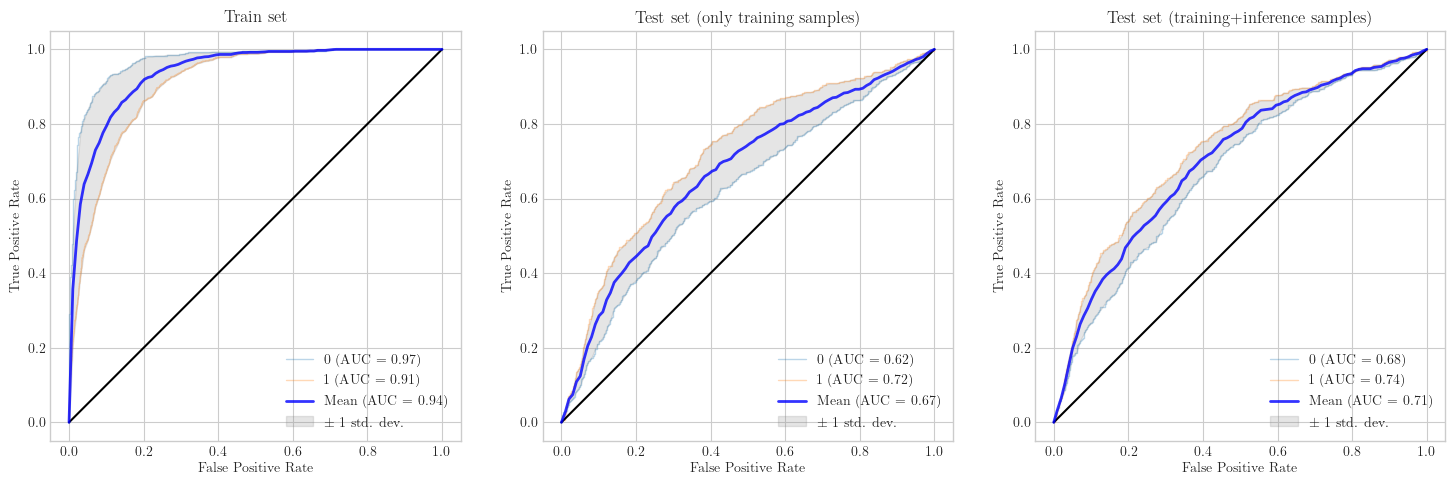

In [79]:
if DO_CV:
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    plot_cross_validation_roc(pred_y_train_list, obs_y_train_list, axs[0])
    plot_cross_validation_roc(pred_y_test2_list, obs_y_test2_list, axs[1])
    plot_cross_validation_roc(pred_y_test_list, obs_y_test_list, axs[2])


    axs[0].set_title("Train set")
    axs[1].set_title("Test set (only training samples)")
    axs[2].set_title("Test set (training+inference samples)")
else:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_cross_validation_roc(pred_y_train_list, obs_y_train_list, axs[0])
    plot_cross_validation_roc(pred_y_test2_list, obs_y_test2_list, axs[1])

    axs[0].set_title("Train set")
    axs[1].set_title("Test set (only training samples)")

## Scale outputs

Scale the results to match the literature value for overall relative frequency of 11% (Buragohain et al., 2021).

In [88]:
pred_y_test = np.concatenate(pred_y_test_list[:2])
obs_y_test = np.concatenate(obs_y_test_list[:2])

In [89]:
scaling_factor = 0.11 / pred_y_test.mean()

## Calibration curve

Calculate and plot the calibration curve (predicted risk over observed relative frequency).

In [81]:
N_BINS = 50

bins = np.linspace(0, 1, N_BINS+1)
predicted_risk = np.histogram(pred_y_test, bins=bins, weights=pred_y_test)[
    0] / np.histogram(pred_y_test, bins=bins)[0]
presence_percentage = np.histogram(pred_y_test, bins=bins, weights=obs_y_test)[
    0] / np.histogram(pred_y_test, bins=bins)[0]
samples_hist = np.histogram(pred_y_test, bins=bins)[0]

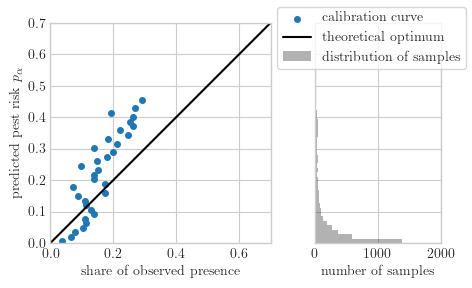

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2.9), sharey=True, gridspec_kw={'width_ratios': [70, 30]})

ax2, ax = axs
ax.hist(pred_y_test*scaling_factor, color="black", alpha=0.3,
        bins=bins*scaling_factor, label=r"distribution of samples", orientation="horizontal")
ax.grid("off")

ax2.scatter(
        presence_percentage[samples_hist > 20]*scaling_factor,
        predicted_risk[samples_hist > 20]*scaling_factor,
        label=r"calibration curve",
        s=16,
        marker="o"
        )

ax2.set_ylabel(r"predicted pest risk $p_\alpha$")
ax2.set_xlabel("share of observed presence")
ax.set_xlabel("number of samples")


ax2.set_xlim(0, 0.7)
ax2.set_ylim(0, 0.7)
ax.set_xlim(0, 2000)

#ax2.grid(None)
ax2.set_aspect("equal")


ax2.plot((0, 1), (0, 1), color="black",
         label=r"theoretical optimum")
fig.legend(frameon=True)

fig.tight_layout()

## Risk, EVPI and recommendation maps

Train the model using the training set for further analyis.

In [142]:
model, likelihood, optimizer = train_model(train_X, train_y)

Iter 10/512 - Loss: 0.814
Iter 20/512 - Loss: 0.739
Iter 30/512 - Loss: 0.662
Iter 40/512 - Loss: 0.604
Iter 50/512 - Loss: 0.559
Iter 60/512 - Loss: 0.522
Iter 70/512 - Loss: 0.49
Iter 80/512 - Loss: 0.463
Iter 90/512 - Loss: 0.443
Iter 100/512 - Loss: 0.427
Iter 110/512 - Loss: 0.416
Iter 120/512 - Loss: 0.407
Iter 130/512 - Loss: 0.4
Iter 140/512 - Loss: 0.393
Iter 150/512 - Loss: 0.387
Iter 160/512 - Loss: 0.382
Iter 170/512 - Loss: 0.376
Iter 180/512 - Loss: 0.371
Iter 190/512 - Loss: 0.367
Iter 200/512 - Loss: 0.362
Iter 210/512 - Loss: 0.359
Iter 220/512 - Loss: 0.355
Iter 230/512 - Loss: 0.352
Iter 240/512 - Loss: 0.349
Iter 250/512 - Loss: 0.347
Iter 260/512 - Loss: 0.345
Iter 270/512 - Loss: 0.342
Iter 280/512 - Loss: 0.34
Iter 290/512 - Loss: 0.34
Iter 300/512 - Loss: 0.337
Iter 310/512 - Loss: 0.335
Iter 320/512 - Loss: 0.335
Iter 330/512 - Loss: 0.332
Iter 340/512 - Loss: 0.33
Iter 350/512 - Loss: 0.329
Iter 360/512 - Loss: 0.328
Iter 370/512 - Loss: 0.327
Iter 380/512 - L

Download and load geometry of Andhra Pradesh

In [143]:
!git clone https://github.com/AnujTiwari/India-State-and-Country-Shapefile-Updated-Jan-2020.git

fatal: destination path 'India-State-and-Country-Shapefile-Updated-Jan-2020' already exists and is not an empty directory.


In [144]:
crs = 4326
states = gpd.read_file("India-State-and-Country-Shapefile-Updated-Jan-2020/India_State_Boundary.shp")
states.to_crs(epsg=crs, inplace=True)

In [145]:
ap_geometry = states.loc[states.State_Name=="Andhra Pradesh"].geometry.iat[0]

Load the geometry of the weather data grid, as well as the weather data.
The same grid and weather data was used to create the training dataset. Now we will use it for inference over the entire spatial domain for a given date to create a map.

In [146]:
grid = gpd.read_file("pest-risk-decision/data/grid.geojson")
wdf = pd.read_feather("pest-risk-decision/data/total_processed.feather")

In [147]:
grid.tail()

,cell_id,geometry
2386,"837,194","POLYGON ((83.70038 19.40009, 83.80038 19.40009..."
2387,"838,194","POLYGON ((83.80038 19.40009, 83.90038 19.40009..."
2388,"845,194","POLYGON ((84.50039 19.40009, 84.60039 19.40009..."
2389,"846,194","POLYGON ((84.60039 19.40009, 84.70039 19.40009..."
2390,"847,194","POLYGON ((84.70039 19.40009, 84.80039 19.40009..."


In [148]:
wdf.tail()

,index,cell_id,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,surface_pressure,solar_radiation,temperature,total_evaporation_sum,precipitation,date,...,wind_speed_l20,wind_speed_l21,wind_speed_l22,wind_speed_l23,wind_speed_l24,wind_speed_l25,wind_speed_l26,wind_speed_l27,wind_speed_l28,wind_speed_l29
5348662,2386,"837,194",3.795888,2.365606,97671.906250,14555920.0,296.718811,-0.001514,0.000002,2200,...,0.699615,1.118871,1.272630,1.023858,0.891740,1.041974,0.769346,0.856535,0.878885,0.539696
5348663,2387,"838,194",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5348664,2388,"845,194",2.041061,2.243357,100255.695312,16355652.0,295.858612,-0.001757,0.000002,2200,...,0.279345,0.498647,0.562910,0.422197,0.190141,0.191832,0.440948,0.370164,0.390498,0.246463
5348665,2389,"846,194",2.224131,2.068019,101034.531250,16399320.0,296.103088,-0.001735,0.000002,2200,...,0.216956,0.553053,0.668663,0.511033,0.248567,0.171957,0.503147,0.322913,0.345988,0.182223
5348666,2390,"847,194",2.066040,2.186401,100998.320312,16427780.0,296.044006,-0.001693,0.000002,2200,...,0.256103,0.734374,0.922912,0.741451,0.580945,0.423709,0.665768,0.413352,0.225915,0.228956


In [149]:
ap_within = grid.intersects(ap_geometry)

set some example days to create the maps for and then print them


In [150]:
days = np.array([1461, 1551, 1704])

In [151]:
for day in days:
    print(destandardize_date(day, reference_day).strftime("%Y-%m-%d"))

2022-01-01
2022-04-01
2022-09-01


Do the inference

In [152]:
wdf_days = []
for i, day in enumerate(days):
    # use a particular day
    wdf_day = wdf.loc[wdf["date"] == day]

    # create gdf, use the centroids as locations for inference
    wdf_day = gpd.GeoDataFrame(pd.merge(wdf_day, grid, on="cell_id", how="left"))
    centroids = wdf_day["geometry"].to_crs('EPSG:7755').centroid.to_crs('EPSG:4326')
    wdf_day["longitude"] = centroids.x
    wdf_day["latitude"] = centroids.y

    # drop cells with no or incomplete weather data
    wdf_day.dropna(inplace=True)

    # use preprocessor to normalize the data in the exact same way as the training data was
    X_map = torch.from_numpy(data_preprocessor.get_X_numpy(wdf_day)).float().contiguous().to(device)

    # days to use for inference form the training set and the testing set (only days prior to the predicted day)
    test_day = day / 365
    obs_mask_test = test_X[:, 2] < test_day
    obs_mask_train = train_X[:, 2] < test_day

    obs_X = torch.vstack((train_X[obs_mask_train], test_X[obs_mask_test, :]))#[-14000:, :]
    obs_y = torch.cat((train_y[obs_mask_train], test_y[obs_mask_test]))#[-14000:]

    # fit the SVI
    inference_model, inference_likelihood, _ = train_model(obs_X, obs_y, model.to(device), likelihood, optimizer)

    # get the predicted probabilities and store them in the map dataframe
    with torch.no_grad():
        pred_map = inference_likelihood(inference_model(X_map))
        wdf_day["gp_pred"] = pred_map.mean.cpu().numpy() * scaling_factor

    wdf_days.append(wdf_day)

	Iter 10/ 50 - Loss: 0.338
	Iter 20/ 50 - Loss: 0.322
	Iter 30/ 50 - Loss: 0.317
	Iter 40/ 50 - Loss: 0.316
	Iter 50/ 50 - Loss: 0.315
	Iter 10/ 50 - Loss: 0.361
	Iter 20/ 50 - Loss: 0.345
	Iter 30/ 50 - Loss: 0.336
	Iter 40/ 50 - Loss: 0.332
	Iter 50/ 50 - Loss: 0.331
	Iter 10/ 50 - Loss: 0.33
	Iter 20/ 50 - Loss: 0.317
	Iter 30/ 50 - Loss: 0.313
	Iter 40/ 50 - Loss: 0.312
	Iter 50/ 50 - Loss: 0.312


3it [00:01,  1.60it/s]


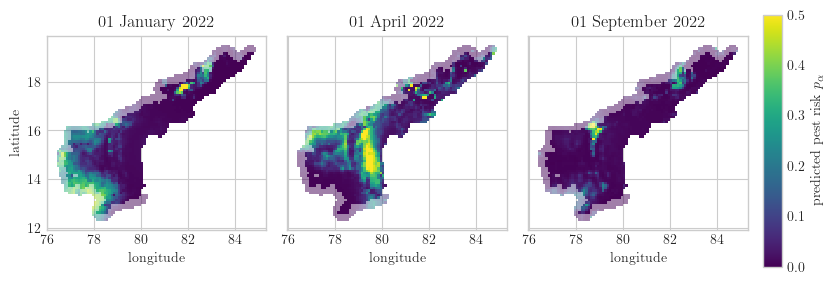

In [167]:
vmax = 0.50

fig, axs = plt.subplots(1, 3, figsize=(9.6, 2.8), sharex=True, sharey=True)
for i, day in tqdm(enumerate(days[:3])):
    ax = axs[i%3]

    wdf_day = wdf_days[i]

    wdf_day.plot(
        column="gp_pred",
        cmap="viridis",
        vmin=0.0,
        vmax=vmax,
        legend=False,
        ax=ax,
        alpha=0.5,
    )

    plot = wdf_day.loc[ap_within].plot(
        column="gp_pred",
        cmap="viridis",
        vmin=0.0,
        vmax=vmax,
        legend=False,
        ax=ax
    )

    ax.set_title(beauty_print_date(destandardize_date(day, reference_day)))
    ax.set_xlabel("longitude")

    if i%3 == 0:
        ax.set_ylabel("latitude")

cbar_ax = fig.add_axes([0.80, 0.05, 0.02, 0.9])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"predicted pest risk $p_\alpha$")

plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make room for colorbar
pass

### Define decision model
Use the basic costs from the paper

In [140]:
e_c_loss_treatment = 0                                          # model is shifted so that there is assumed zero yield loss given treatment
e_c_loss_no_treatment = 868                                     # INR of yield loss per ha per day given no treatmen
e_c_treatment_application = 795                                 # INR treatment costs per ha per application
e_c_monitoring = 48                                             # INR monitoring costs per ha per day
e_c_treatment_treatment = e_c_treatment_application/10 - 24     # INR treatment costs per ha per day given treatment

Implement the cost and EVPI functions

In [168]:
def expected_cost(
    p_pest,                     # probability of pest occurence
    treatment,                  # treatment indicator (decision variable)
    e_c_loss_treatment,         # expected cost of yield loss given treatment
    e_c_loss_no_treatment,      # expected cost of yield loss given no treatment
    e_c_treatment_treatment,    # expected cost of treatment given treatment
):
    e_c_loss_pest = treatment * e_c_loss_treatment \
             + (1-treatment) * e_c_loss_no_treatment
    e_c_loss = p_pest * e_c_loss_pest

    e_c_treatment = treatment * e_c_treatment_treatment
    return e_c_loss + e_c_treatment


def expected_hat_cost(
    p_pest,                     # probability of pest occurence
    treatment,                  # treatment indicator (decision variable)
    e_c_loss_treatment,         # expected cost of yield loss given treatment
    e_c_loss_no_treatment,      # expected cost of yield loss given no treatment
    e_c_treatment_treatment,    # expected cost of treatment given treatment
):
    e_c = expected_cost(
        p_pest,
        treatment,
        e_c_loss_treatment,
        e_c_loss_no_treatment,
        e_c_treatment_treatment,
    )

    shift = p_pest * e_c_loss_no_treatment
    return e_c - shift

def e_c_hat_given_no_ppi(
    p_pest,                     # probability of pest occurence
    e_c_loss_treatment,         # expected cost of yield loss given treatment
    e_c_loss_no_treatment,      # expected cost of yield loss given no treatment
    e_c_treatment_treatment,    # expected cost of treatment given treatment
):
    e_c_treatment = expected_hat_cost(
        p_pest,
        1,
        e_c_loss_treatment,
        e_c_loss_no_treatment,
        e_c_treatment_treatment,
    )
    e_c_no_treatment = expected_hat_cost(
        p_pest,
        0,
        e_c_loss_treatment,
        e_c_loss_no_treatment,
        e_c_treatment_treatment,
    )
    return np.minimum(e_c_treatment, e_c_no_treatment)

def e_c_hat_given_ppi(
    p_pest,                     # probability of pest occurence
    e_c_loss_treatment,         # expected cost of yield loss given treatment
    e_c_loss_no_treatment,      # expected cost of yield loss given no treatment
    e_c_treatment_treatment,    # expected cost of treatment given treatment
):
    return p_pest * expected_hat_cost(
        1,
        1,
        e_c_loss_treatment,
        e_c_loss_no_treatment,
        e_c_treatment_treatment,
    )

def evppi(
    p_pest,                     # probability of pest occurence
    e_c_loss_treatment,         # expected cost of yield loss given treatment
    e_c_loss_no_treatment,      # expected cost of yield loss given no treatment
    e_c_treatment_treatment,    # expected cost of treatment given treatment
):
    return e_c_hat_given_no_ppi(
        p_pest,
        e_c_loss_treatment,
        e_c_loss_no_treatment,
        e_c_treatment_treatment,
    ) - \
    e_c_hat_given_ppi(
        p_pest,
        e_c_loss_treatment,
        e_c_loss_no_treatment,
        e_c_treatment_treatment,
    )

def e_u_gamma(p_alpha, gamma):
    if gamma == 0:
        return p_alpha * 0
    elif gamma == 1:
        return p_alpha * (e_c_loss_no_treatment - e_c_loss_treatment - e_c_treatment_treatment) - e_c_monitoring
    elif gamma == 2:
        return p_alpha * (e_c_loss_no_treatment - e_c_loss_treatment) - e_c_treatment_treatment

Show the EVPI as a map

3it [00:01,  1.51it/s]


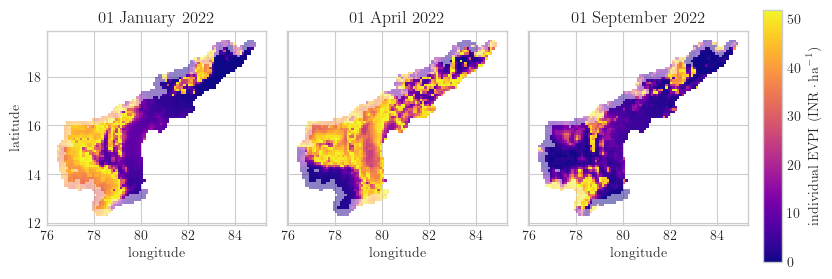

In [170]:
cmap = "plasma"

fig, axs = plt.subplots(1, 3, figsize=(9.6, 2.8), sharey=True)

for i, day in tqdm(enumerate(days[:3])):

    wdf_day = wdf_days[i]
    ax = axs[i]

    wdf_day["individual_evpi"] = evppi(
        wdf_day["gp_pred"],                     # probability of pest occurence
        e_c_loss_treatment,         # expected cost of yield loss given treatment
        e_c_loss_no_treatment,      # expected cost of yield loss given no treatment
        e_c_treatment_treatment,    # expected cost of treatment given treatment
    )

    vmin = wdf_day.individual_evpi.min()
    vmax = wdf_day.individual_evpi.max()

    wdf_day.plot(
        column="individual_evpi",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=False,
        ax=ax,
        alpha=0.5,
    )

    wdf_day.loc[ap_within].plot(
        column="individual_evpi",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,

        legend=False,
        ax=ax
    )

    ax.set_title("{}".format(beauty_print_date(destandardize_date(day, reference_day))))

    ax.set_xlabel("longitude")

    if i==0:
        ax.set_ylabel("latitude")

cbar_ax = fig.add_axes([0.80, 0.05, 0.02, 0.9])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"individual EVPI ($\text{INR}\cdot\text{ha}^{-1}$)")

plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make room for colorbar

pass

Show the decision recommendation on a map

3it [00:02,  1.19it/s]


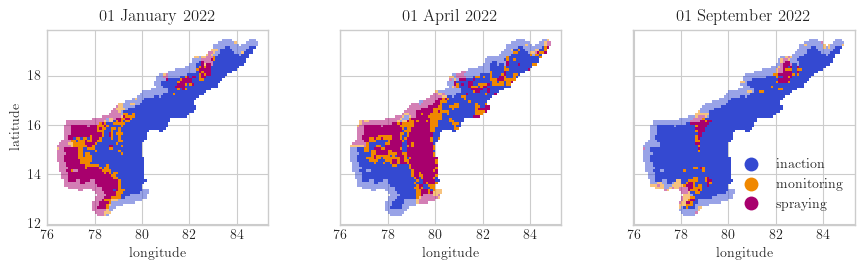

In [173]:
fig, axs = plt.subplots(1, 3, figsize=(9.6, 2.8), sharey=True)

cmap = matplotlib.colors.ListedColormap(['#3449d1', '#f08800', '#a8006d'])

for i, day in tqdm(enumerate(days[:3])):

    wdf_day = wdf_days[i]
    ax = axs[i]

    e_u = np.empty((len(wdf_day), 3))
    e_u[:, 0] = e_u_gamma(
        wdf_day["gp_pred"],                     # probability of pest occurence
        0
    )
    e_u[:, 1] = e_u_gamma(
        wdf_day["gp_pred"],                     # probability of pest occurence
        1
    )
    e_u[:, 2] = e_u_gamma(
        wdf_day["gp_pred"],                     # probability of pest occurence
        2
    )

    suggestion_names = np.array(["inaction", "monitoring", "spraying"])
    wdf_day["suggestion"] = suggestion_names[np.argmax(e_u, axis=1)]

    vmin = wdf_day.individual_evpi.min()
    vmax = wdf_day.individual_evpi.max()

    wdf_day.plot(
        column="suggestion",
        cmap=cmap,
        legend=False,
        ax=ax,
        alpha=0.5,
    )

    wdf_day.loc[ap_within].plot(
        column="suggestion",
        cmap=cmap,
        legend=i==2,
        ax=ax
    )

    ax.set_title("{}".format(beauty_print_date(destandardize_date(day, reference_day))))

    ax.set_xlabel("longitude")

    if i==0:
        ax.set_ylabel("latitude")

    if i==2:
        legend = ax.get_legend()
        legend.set_bbox_to_anchor((1, 0.4))

    plt.tight_layout()  # Adjust layout to make room for colorbar
    pass

Create one giant map

3it [00:08,  2.70s/it]


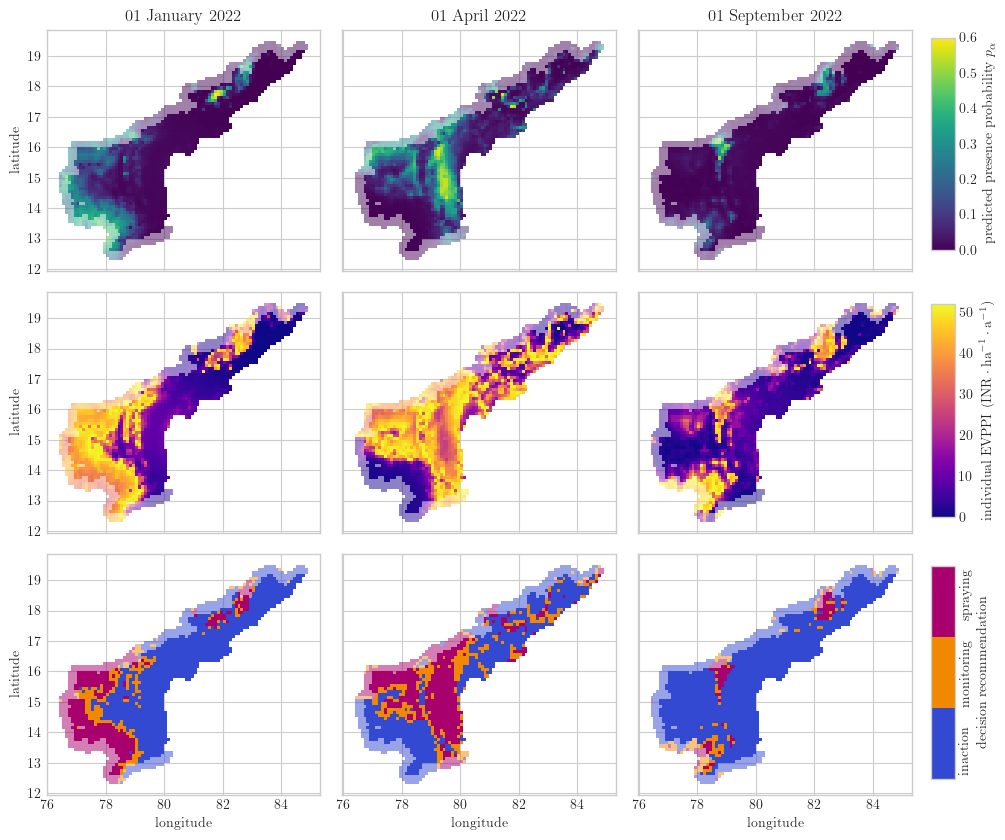

In [175]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8.5), sharex=True, sharey=True)
for i, day in tqdm(enumerate(days[:3])):
    ax = axs[0, i%3]

    wdf_day = wdf_days[i]
    df_day = df.loc[(df["date"] >= day-5) & (df["date"] <= day)]
    vmax = 0.60

    wdf_day.plot(
        column="gp_pred",
        cmap="viridis",
        vmin=0.0,
        vmax=vmax,
        legend=False,
        ax=ax,
        alpha=0.5,
    )

    plot = wdf_day.loc[ap_within].plot(
        column="gp_pred",
        cmap="viridis",
        vmin=0.0,
        vmax=vmax,
        legend=False,
        ax=ax
    )
    ax.set_title(beauty_print_date(destandardize_date(day, reference_day)))

    if i%3 == 0:
        ax.set_ylabel("latitude")

    ax = axs[1, i%3]
    cmap2 = "plasma"

    wdf_day["individual_evpi"] = evppi(
            wdf_day["gp_pred"],                     # probability of pest occurence
            e_c_loss_treatment,         # expected cost of yield loss given treatment
            e_c_loss_no_treatment,      # expected cost of yield loss given no treatment
            e_c_treatment_treatment,    # expected cost of treatment given treatment
    )

    vmin2 = wdf_day.individual_evpi.min()
    vmax2 = wdf_day.individual_evpi.max()

    wdf_day.plot(
        column="individual_evpi",
        cmap=cmap2,
        vmin=vmin2,
        vmax=vmax2,
        legend=False,
        ax=ax,
        alpha=0.5,
    )

    wdf_day.loc[ap_within].plot(
        column="individual_evpi",
        cmap=cmap2,
        vmin=vmin2,
        vmax=vmax2,
        legend=False,
        ax=ax
    )
    if i%3 == 0:
        ax.set_ylabel("latitude")

    ax = axs[2, i%3]

    cmap3 = matplotlib.colors.ListedColormap(['#3449d1', '#f08800', '#a8006d'])

    e_u = np.empty((len(wdf_day), 3))
    e_u[:, 0] = e_u_gamma(
        wdf_day["gp_pred"],                     # probability of pest occurence
        0
    )
    e_u[:, 1] = e_u_gamma(
        wdf_day["gp_pred"],                     # probability of pest occurence
        1
    )
    e_u[:, 2] = e_u_gamma(
        wdf_day["gp_pred"],                     # probability of pest occurence
        2
    )

    suggestion_names = np.array(["inaction", "monitoring", "spraying"])
    wdf_day["suggestion"] = np.argmax(e_u, axis=1)

    vmin3 = wdf_day.individual_evpi.min()
    vmax3 = wdf_day.individual_evpi.max()

    wdf_day.plot(
        column="suggestion",
        cmap=cmap3,
        legend=False,
        ax=ax,
        alpha=0.5,
    )

    wdf_day.loc[ap_within].plot(
        column="suggestion",
        cmap=cmap3,
        legend=False,
        ax=ax
    )

    ax.set_xlabel("longitude")
    if i%3 == 0:
        ax.set_ylabel("latitude")



cbar_ax = fig.add_axes([0.78, 0.70, 0.02, 0.25])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"predicted presence probability $p_\alpha$")



cbar_ax = fig.add_axes([0.78, 0.386, 0.02, 0.25])
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=vmax2))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"individual EVPPI ($\text{INR}\cdot\text{ha}^{-1} \cdot\text{a}^{-1}$)")

cbar_ax = fig.add_axes([0.78, 0.078, 0.02, 0.25])
sm = plt.cm.ScalarMappable(cmap=cmap3)
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0.22, 0.62, 0.96])
cbar.ax.set_yticklabels(suggestion_names)
for label in cbar.ax.get_yticklabels():
    label.set_rotation(90)  # Rotate the tick labels by 45 degrees
cbar.set_label(r"decision recommendation")

plt.tight_layout(rect=[0, 0, 0.8, 1])